In [1]:
import numpy as np
import math
from scipy.stats import norm
from matplotlib import pyplot as plt
from numpy import linalg as LA
from scipy.stats import unitary_group
from scipy.integrate import quad
from scipy import integrate
import random
# import concurrent.futures
import multiprocessing
import os
from scipy import stats
from mpl_toolkits import mplot3d
import scipy.integrate as spi
rho_a =1
rho_q=1
M = 1 #scalar

In [2]:
def MSE_zertothresh_analytic(sigma,n_q):
    alpha = (2 / math.pi) * math.acos(rho_q / (rho_q + pow(sigma, 2)))
    beta = ((1-alpha)/rho_q)
    second = (2*rho_q*n_q)/(math.pi*(rho_q+pow(sigma, 2))*(alpha+beta*rho_q*n_q))
    return M*(1-second)

In [3]:
def CRB(mu,sigma,thresh_real=0,observ=1000): 
    teta_samp = np.random.normal(mu, 1, (M, observ)).reshape(M,observ)
    zeta_real = ((1/sigma)*(teta_samp.real-thresh_real))
    pdf_real = norm.pdf(zeta_real)
    d_vec = np.divide(np.power(pdf_real, 2), np.multiply(norm.cdf(zeta_real), (norm.cdf(-zeta_real))))
    d = np.mean(d_vec, axis=1) #converges to 0.95 aprox.
    J_q = np.sum(d,axis=0)*(1/(pow(sigma, 2)))
    J = np.identity(M) + J_q
    return LA.norm((LA.inv(J)).real,"fro")

In [4]:
def inner(theta,sigma,s,h,thresh_real): 
    return pow(norm.cdf((1/sigma)*(theta+h-thresh_real)),s)*\
    pow(norm.cdf((1/sigma)*(theta-thresh_real)),1-s)+\
    pow(norm.cdf(-(1/sigma)*(theta+h-thresh_real)),s)*\
    pow(norm.cdf(-(1/sigma)*(theta-thresh_real)),1-s)
def ratio_func(theta,mu,sigma2,s,h,thresh_real):
    return pow(1/(math.sqrt(2*math.pi))*math.exp(-0.5*((theta-mu+h)**2)),s)*pow(1/(math.sqrt(2*math.pi))*math.exp(-0.5*((theta-mu)**2)),1-s)*inner(theta,sigma2,s,h,thresh_real)
def etha(mu,sigma2,s,h,thresh_real):
    expected_value, _ = quad(ratio_func,-15, 15, args=(mu,sigma2,s,h,thresh_real))
    return math.log(expected_value)
def WWS(mu,sigma2,s,h,thresh_real=0): 
    return (h**2)*(math.e**(2*etha(mu,sigma2,s,h,thresh_real)))/(math.e**(etha(mu,sigma2,2*s,h,thresh_real))+math.e**(etha(mu,sigma2,2-2*s,-h,thresh_real))-2*math.e**(etha(mu,sigma2,s,2*h,thresh_real)))
    #(h**2)*(math.e**(2*etha(sigma2,s,h,thresh_real)))/(2*(1-math.e**(etha(sigma2,s,2*h,thresh_real)))) for s=0.5

In [5]:
def gaussian_distri(mu,argu):
    return (1/(math.sqrt(2*math.pi)))*math.exp(-0.5*((argu-mu+h)**2))
def inner2(theta,sigma,h,thresh_real): 
    return (norm.cdf((1/sigma)*(theta+h-thresh_real))**2/norm.cdf((1/sigma)*(theta-thresh_real)))+\
    (norm.cdf(-(1/sigma)*(theta+h-thresh_real))**2/norm.cdf(-(1/sigma)*(theta-thresh_real)))
def ratio_func2(theta,mu,sigma,h,thresh_real):
    return gaussian_distri(mu,theta+h)**2/gaussian_distri(mu,theta)*inner2(theta,sigma,h,thresh_real)-\
    2*gaussian_distri(mu,theta+h)*(norm.cdf((1/sigma)*(theta+h-thresh_real))+norm.cdf(-(1/sigma)*(theta+h-thresh_real)))+\
    gaussian_distri(mu,theta)*(norm.cdf((1/sigma)*(theta-thresh_real))+norm.cdf(-(1/sigma)*(theta-thresh_real)))
def integ(mu,sigma2,h,thresh_real):
    expected_value, _ = quad(ratio_func2,-15, 15, args=(mu,sigma2,h,thresh_real))
    return math.log(expected_value)
def BBZ(mu,sigma,h,thresh_real=0): 
    return (h**2)/(integ(mu,sigma,h,thresh_real))
# def proba(mu,sigma,xq,theta,thresh_real=0,thresh_im=0):
#     zeta_real = ((math.sqrt(2)/sigma)*((theta).real-thresh_real))
#     zeta_im = ((math.sqrt(2)/sigma)*((theta).imag-thresh_im))
#     p_theta = 1/(pow(math.pi,M))*np.exp(-np.linalg.norm (theta-mu)**2)
#     f_xq = np.prod(np.power(norm.cdf(zeta_real),(0.5-xq.real/math.sqrt(2)).reshape(-1,1)))\
#     *np.prod(np.power(norm.cdf(zeta_im),(0.5+xq.imag/math.sqrt(2)).reshape(-1,1)))*np.prod(np.power(norm.cdf(-zeta_real),(0.5-xq.real/math.sqrt(2)).reshape(-1,1)))*np.prod(np.power(norm.cdf(-zeta_im),(0.5-xq.imag/math.sqrt(2)).reshape(-1,1)))
#     return p_theta*f_xq
# 
# def x(mu,sigma,theta,thresh_real=0,thresh_im=0): #the observations- function of teta
#     n_q=1
#     sigma_w_q = sigma * (1 / math.sqrt(2))
#     real_w_q = np.random.normal(mu, sigma_w_q, M*n_q)
#     im_w_q = np.random.normal(mu, sigma_w_q, M*n_q)
#     w_q = real_w_q + 1j * im_w_q
#     w_q = w_q.reshape(M*n_q, 1)
# 
#     if M>1:
#         y = theta+w_q
#     else:
#         y = theta+w_q
# 
#     x_q = (1/math.sqrt(2))*(np.sign(y.real-(thresh_real))+1j*np.sign(y.imag-((thresh_im))))
#     return x_q#.reshape(M*n_q,)
# 
# def BBZ(mu,sigma, h,observ=10000,thresh_real=0,thresh_im=0): #TODO (WWB style)
#     E = np.zeros((observ))
#     for i in range(observ):
#         real_teta = np.random.normal(mu, 1,M)
#         teta = real_teta
#         teta = teta.reshape(M,1)
#         x_q = x(mu,sigma,teta,thresh_real,thresh_im)  # function of teta
#         counter = proba(mu,sigma,x_q,teta+h) 
#         devide = proba(mu,sigma,x_q,teta) 
#         E[i] = pow(counter/devide-1,2)
#     E = np.mean(E, 0)
#     return pow(h,2)/E

C:\Users\Yaniv\AppData\Local\Temp\ipykernel_7012\3721796381.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return (norm.cdf((1/sigma)*(theta+h-thresh_real))**2/norm.cdf((1/sigma)*(theta-thresh_real)))+\
C:\Users\Yaniv\AppData\Local\Temp\ipykernel_7012\3721796381.py:5: RuntimeWarning: invalid value encountered in double_scalars
  (norm.cdf(-(1/sigma)*(theta+h-thresh_real))**2/norm.cdf(-(1/sigma)*(theta-thresh_real)))
C:\Users\Yaniv\AppData\Local\Temp\ipykernel_7012\3721796381.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  expected_value, _ = quad(ratio_func2,-15, 15, args=(mu,sigma2,h,thresh_real))


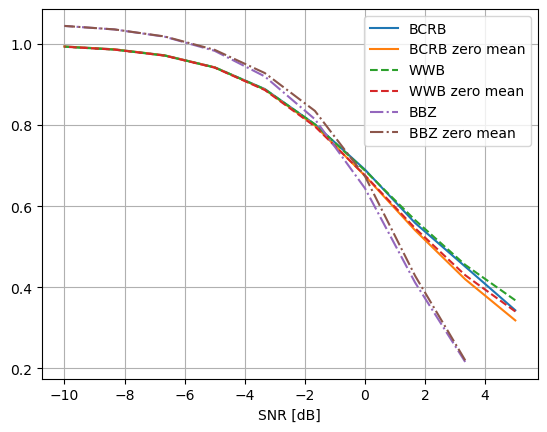

In [9]:
s= 0.5
h= 0.5
mu1=h
h2 = 1.5
sigma_space_new = np.logspace(-0.5, 1, 10)
CRB1 = [CRB(mu1,sigma_space_new[i]) for i in range(len(sigma_space_new))]
CRB2 = [CRB(0,sigma_space_new[i]) for i in range(len(sigma_space_new))]
WWS1 = [WWS(mu1,sigma_space_new[i],s,h) for i in range(len(sigma_space_new))]
WWS2 = [WWS(0,sigma_space_new[i],s,h) for i in range(len(sigma_space_new))]
BBZ1 = [BBZ(mu1,sigma_space_new[i],h2) for i in range(len(sigma_space_new))]
BBZ2 = [BBZ(0,sigma_space_new[i],h2) for i in range(len(sigma_space_new))]
plt.figure()
plt.plot(10*np.log10(1/sigma_space_new), CRB1, label = "BCRB")
plt.plot(10*np.log10(1/sigma_space_new), CRB2, label = "BCRB zero mean")
plt.plot(10*np.log10(1/sigma_space_new), WWS1, linestyle = "--", label = "WWB")
plt.plot(10*np.log10(1/sigma_space_new), WWS2, linestyle = "--", label = "WWB zero mean")
plt.plot(10*np.log10(1/sigma_space_new), BBZ1, linestyle = "-.", label = "BBZ")
plt.plot(10*np.log10(1/sigma_space_new), BBZ2, linestyle = "-.", label = "BBZ zero mean")
# plt.title("WWB & BCRB vs SNR")
plt.xlabel("SNR [dB]")
plt.legend()
plt.grid()

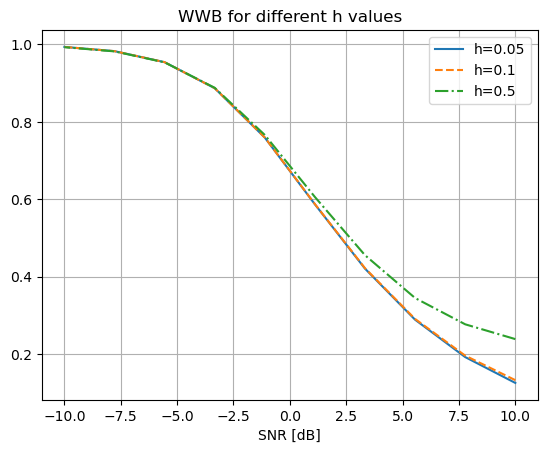

In [11]:
sigma_space_new = np.logspace(-1,1,10)
h= [0.05,0.1,0.5]
s= 0.5
sigma_space_new = np.logspace(-1, 1, 10)
WWS1 = [WWS(-h[0],sigma_space_new[i],s,h[0]) for i in range(len(sigma_space_new))]
WWS2 = [WWS(-h[1],sigma_space_new[i],s,h[1]) for i in range(len(sigma_space_new))]
WWS3 = [WWS(-h[2],sigma_space_new[i],s,h[2]) for i in range(len(sigma_space_new))]

plt.figure()
plt.plot(10*np.log10(1/sigma_space_new), WWS1, linestyle = "-", label = f"h={h[0]}")
plt.plot(10*np.log10(1/sigma_space_new), WWS2, linestyle = "--", label = f"h={h[1]}")
plt.plot(10*np.log10(1/sigma_space_new), WWS3, linestyle = "-.", label = f"h={h[2]}")

plt.title("WWB for different h values")
plt.xlabel("SNR [dB]")
plt.grid()
plt.legend()

C:\Users\Yaniv\AppData\Local\Temp\ipykernel_7012\452393901.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  pow(norm.cdf((1/sigma)*(theta-thresh_real)),1-s)+\
C:\Users\Yaniv\AppData\Local\Temp\ipykernel_7012\452393901.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return pow(norm.cdf((1/sigma)*(theta+h-thresh_real)),s)*\
C:\Users\Yaniv\AppData\Local\Temp\ipykernel_7012\452393901.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  pow(norm.cdf(-(1/sigma)*(theta-thresh_real)),1-s)
C:\Users\Yaniv\AppData\Local\Temp\ipykernel_7012\452393901.py:4: RuntimeWarning: invalid value encountered in double_scalars
  pow(norm.cdf(-(1/sigma)*(theta+h-thresh_real)),s)*\
C:\Users\Yaniv\AppData\Local\Temp\ipykernel_7012\452393901.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  expected_value, _ = quad(ratio_func,-15, 15, a

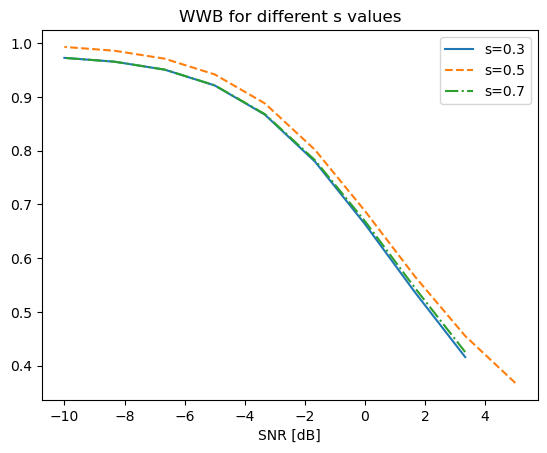

In [13]:
s= [0.3,0.5,0.7]
h= 0.5
mu3=0
sigma_space_new = np.logspace(-0.5, 1, 10)
WWS1 = [WWS(s[0],sigma_space_new[i],s[0],h) for i in range(len(sigma_space_new))]
WWS2 = [WWS(s[1],sigma_space_new[i],s[1],h) for i in range(len(sigma_space_new))]
WWS3 = [WWS(s[2],sigma_space_new[i],s[2],h) for i in range(len(sigma_space_new))]

plt.figure()
plt.plot(10*np.log10(1/sigma_space_new), WWS1, linestyle = "-", label = f"s={s[0]}")
plt.plot(10*np.log10(1/sigma_space_new), WWS2, linestyle = "--", label = f"s={s[1]}")
plt.plot(10*np.log10(1/sigma_space_new), WWS3, linestyle = "-.", label = f"s={s[2]}")

plt.title("WWB for different s values")
plt.xlabel("SNR [dB]")
plt.legend()

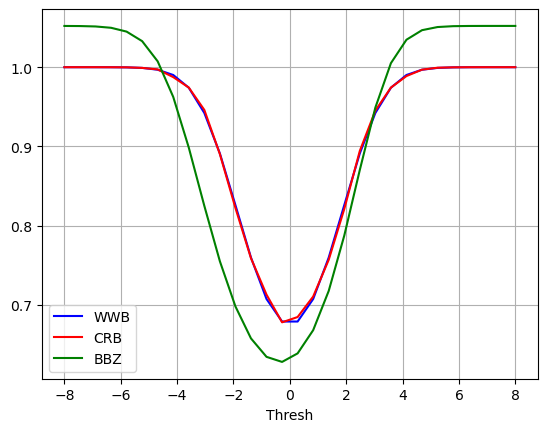

In [14]:
s= 0.5
h= 0.1
my_sigma = 1 #Thresh = Thresh/sigma
thresh_space = np.linspace(-8,8,30)
WWS1 = [WWS(0,my_sigma,s,h,thresh_space[i]) for i in range(len(thresh_space))]
CRB1 = [CRB(0,my_sigma,thresh_space[i]) for i in range(len(thresh_space))]
BBZ1 = [BBZ(mu1,my_sigma,h2,thresh_space[i]) for i in range(len(thresh_space))]
# CRB1 = [CRB(mu_crb,0.5*thresh_space[i],thresh_space[i]) for i in range(len(thresh_space))]

plt.figure()
plt.plot(thresh_space, WWS1, color = "blue", label = "WWB")
plt.plot(thresh_space, CRB1, color = "red", label = "CRB")
plt.plot(thresh_space, BBZ1, color = "green", label = "BBZ")
plt.xlabel("Thresh")
plt.legend()
plt.grid()

ZVI ZAKAI: #TODO 

In [36]:
def Pmin(theta,h,sigma):
    P1 = norm.cdf((theta+h)/sigma)
    P2 = norm.cdf(theta/sigma)
    P3 = norm.cdf(-(theta+h)/sigma)
    P4 = norm.cdf(-theta/sigma)
    C1 = math.log(P1)
    C2 = math.log(P2)
    C3 = math.log(P3)
    C4 = math.log(P4)
    coun_1 = (math.sqrt(P1*P2)+math.sqrt(P3*P4))*((math.sqrt(P1*P2)*(C1**2+C2**2))
                                                  +(math.sqrt(P3*P4)*(C3**2+C4**2)))
    coun_2 = pow((math.sqrt(P1*P2)*(C1+C2))+(math.sqrt(P3*P4)*(C3+C4)),2)
    dev_mu = (coun_1-coun_2)/pow(math.sqrt(P1*P2)+math.sqrt(P3*P4),2)
    return norm.cdf((1/2)*math.sqrt(dev_mu))
Pmin(0,0,1)

ValueError: math domain error

In [23]:
def f(theta,h,sigma):
    return min(1/(math.sqrt(2*math.pi))*math.exp(-0.5*((theta+h)**2)),1/(math.sqrt(2*math.pi))*math.exp(-0.5*((theta)**2)))*Pmin(theta,h,sigma)*h

def ZVI(sigma):
    result, error = integrate.dblquad(f, -2, 2, 0,8,args=(sigma,))
    return result

In [25]:
sigma_space_new = np.logspace(0, 0.2, 10)
ZVI1 = [ZVI(sigma_space_new[i]) for i in range(len(sigma_space_new))]

ValueError: math domain error